In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
with open('/Users/keshavsanthanam/Downloads/consolidated_throughputs.json', 'r') as f:
    raw_consolidated_throughputs = json.load(f)

In [3]:
with open('/Users/keshavsanthanam/Downloads/unconsolidated_throughputs.json', 'r') as f:
    raw_unconsolidated_throughputs = json.load(f)

In [4]:
raw_consolidated_throughputs = raw_consolidated_throughputs['v100']
raw_unconsolidated_throughputs = raw_unconsolidated_throughputs['v100']

In [5]:
def parse_job_type(job_type):
    model = job_type.split(' ')[0]
    res = re.search('\(batch size (\d+)\)', job_type)
    if res is not None:
        batch_size = int(res.group(1))
    else:
        batch_size = 1
    res = re.search('\(scale factor (\d+)\)', job_type)
    if res is not None:
        scale_factor = int(res.group(1))
    else:
        scale_factor = 1
    return model, batch_size, scale_factor

In [6]:
def plot_throughputs_bar_graph(throughputs, base_model, output_file=None):
    data = []
    for job_type in throughputs:
        model, batch_size, scale_factor = parse_job_type(job_type)
        if model != base_model:
            continue
        throughput = throughputs[job_type]['null'] * batch_size
        data.append((job_type, throughput))
    data.sort(key=lambda x: x[1])
    job_types = [x[0] for x in data]
    throughputs = [x[1] / data[0][1] for x in data]
    x_pos = list(range(len(job_types)))
    plt.barh(job_types, throughputs)
    plt.ylabel('Job type', labelpad=10)
    plt.xlabel('Normalized throughputs (samples / second)')
    plt.yticks(job_types)
    if output_file is not None:
        plt.savefig(output_file, bbox_inches='tight')

In [7]:
def parse_throughputs(raw_throughputs):
    throughputs = {}
    for job_type in raw_throughputs:
        model, batch_size, scale_factor = parse_job_type(job_type)
        if model not in throughputs:
            throughputs[model] = {}
        if batch_size not in throughputs[model]:
            throughputs[model][batch_size] = {}
        throughput = raw_throughputs[job_type]['null'] * batch_size
        throughputs[model][batch_size][scale_factor] = throughput
    return throughputs

In [8]:
def plot_throughputs(consolidated_throughputs, unconsolidated_throughputs,
                     base_model, output_file=None):
    min_batch_size = min(consolidated_throughputs[base_model].keys())
    base_throughput = consolidated_throughputs[base_model][min_batch_size][1]
    colors = ['blue', 'orange', 'green']
    lines = []
    labels = []
    
    for i, batch_size in enumerate(sorted(consolidated_throughputs[base_model].keys())):
        scale_factors = sorted(consolidated_throughputs[base_model][batch_size].keys())
        
        x = sorted(consolidated_throughputs[base_model][batch_size].keys())
        y = [consolidated_throughputs[base_model][batch_size][scale_factor] for scale_factor in scale_factors]
        y_normalized = [y[i] / base_throughput for i in range(len(y))]
        label = 'Batch size %d (consolidated)' % (batch_size)
        line = plt.plot(x, y_normalized, label=label, marker='o', color=colors[i])
        lines.append(line[0])
        labels.append(label)
        
        x = sorted(unconsolidated_throughputs[base_model][batch_size].keys())
        y = [unconsolidated_throughputs[base_model][batch_size][scale_factor] for scale_factor in scale_factors]
        y_normalized = [y[i] / base_throughput for i in range(len(y))]
        label = 'Batch size %d (unconsolidated)' % (batch_size)
        line = plt.plot(x, y_normalized, label=label, linestyle='--', marker='o', color=colors[i])
        lines.append(line[0])
        labels.append(label)
    ax = plt.gca()
    leg = plt.figlegend(lines, labels, loc='lower center', ncol=3)
    # Get the bounding box of the original legend.
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    yOffset = 1.25
    bb.y0 += yOffset
    bb.y1 += yOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    plt.ylim(ymin=0)
    plt.xticks(scale_factors)
    plt.xlabel('Scale factor')
    plt.ylabel('Normalized throughputs (samples / second)')
    if output_file is not None:
        plt.savefig(output_file, bbox_inches='tight')

In [9]:
consolidated_throughputs = parse_throughputs(raw_consolidated_throughputs)
unconsolidated_throughputs = parse_throughputs(raw_unconsolidated_throughputs)

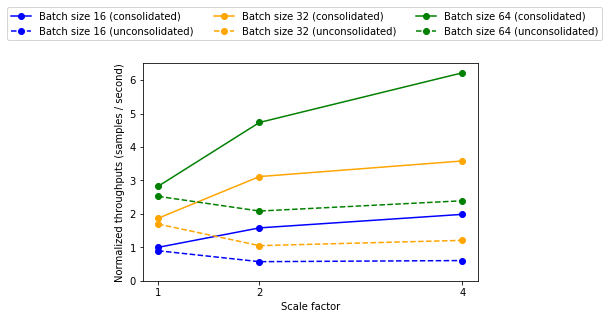

In [10]:
plot_throughputs(consolidated_throughputs, unconsolidated_throughputs,
                 'ResNet-18', 'figures/distributed_throughputs/resnet_18.pdf')

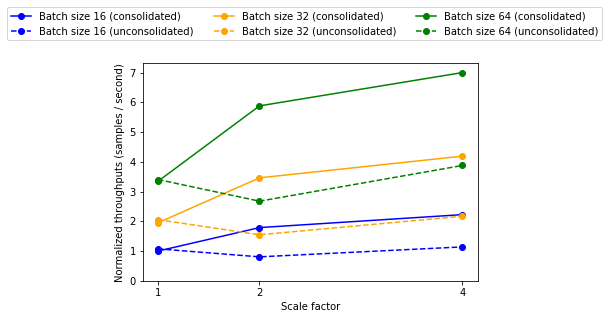

In [11]:
plot_throughputs(consolidated_throughputs, unconsolidated_throughputs,
                 'Transformer', 'figures/distributed_throughputs/transformer.pdf')

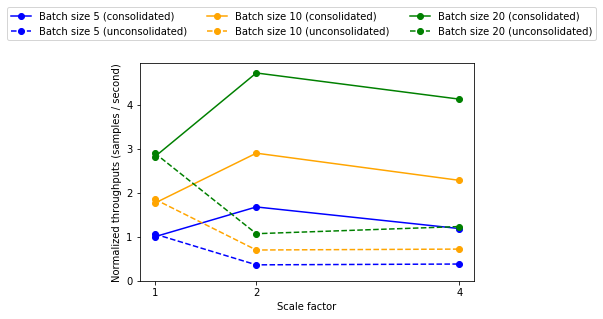

In [12]:
plot_throughputs(consolidated_throughputs, unconsolidated_throughputs,
                 'LM', 'figures/distributed_throughputs/lm.pdf')